In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from scipy.stats import wilcoxon
import scipy.stats as stats
from scipy.stats import ttest_rel
import plotly.express as px
from scipy.stats import shapiro
from scipy.stats import normaltest
import statistics as stat
from scipy.stats import levene
#import pyvttbl as pt
from collections import namedtuple
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
from scipy.stats import friedmanchisquare as fmc
import statannot
import seaborn as sns
import statistics

In [3]:
from matplotlib.pyplot import xlabel, ylabel


filepath = "E:/rajat/laptop_files/dissertation/experiment/SRTT_SEPARATE/"
# filepath = "E:/rajat/laptop_files/dissertation/experiment/srtt_separate_12/"    #11: >1mA : 12: <1mA
filepaths = os.listdir(filepath)
# outliers = []
outliers = ['SUBC3FP2010', 'SUBC3FP2054']

# outliers = ['SUBC3FP2026']
# outliers = ['SUBC3FP2003', 'SUBC3FP2021', 'SUBC3FP2026', 'SUBC3FP2027','SUBC3FP2041', 'SUBC3FP2044','SUBC3FP2045']
blocks = ['block'+str(i+1) for i in range(8)]
block_mean = pd.DataFrame(index = blocks)
block_norm_cent_mean = pd.DataFrame(index = blocks)
block_rt_abs_mean = pd.DataFrame(index = blocks)
block_std = pd.DataFrame(index = blocks)
block_rt_abs_std = pd.DataFrame(index = blocks)
block_rt_abs_er = pd.DataFrame(index = blocks)
block_err = pd.DataFrame(index = blocks)
block_norm_cent_err = pd.DataFrame(index = blocks)
data_files_full = dict()
variability_sub_all_blocks = dict()
data_files = dict()
data_file_cent = dict()
upper_bound = dict()
lower_bound = dict()
error_dict_full = dict()
error_dict_block = dict()
block_er_mean = pd.DataFrame(index = blocks)
block_er_mean_norm = pd.DataFrame(index = blocks)
block_er_sem = pd.DataFrame(index = blocks)
block_er_sem_norm = pd.DataFrame(index = blocks)
anova_file_full = []
final_VAR_file = dict()
an_learn = []
an_learn_cond=[]
an_learn_sub = []
an_learn_nn = []
data_files_abs = dict()
learn_dict = dict()
learn_full = []
learn_df = pd.DataFrame()
data_files_absRT = dict()

for file in filepaths:   
    files = os.listdir(filepath + file +'/')
    files_except_outliers = [i for i in files if i[:11] not in outliers]
    final = pd.DataFrame(index = blocks)
    final_cent = pd.DataFrame(index = blocks)
    final_er_norm = pd.DataFrame(index = blocks)
    final_er = pd.DataFrame(index = blocks)
    final_er_full = pd.DataFrame(index = ['all'])
    final_abs = pd.DataFrame(index = blocks)
    final_var = pd.DataFrame(index = blocks)


    for indexx,i in enumerate(files_except_outliers):
        anova_file = pd.DataFrame()
        filename = i[:13]
        if filename[-1] == '1':
            skip_r = 2957
        else: skip_r = 2896

        df = pd.read_csv(filepath + file +'/' + i, skiprows=skip_r, delimiter = "\t")
        df1 = df[df["Code"].str.len()>5] #to seperate nan and isi from block

        df1[["Block", "Condition", "Target Button", "Trial Number"]] = df1["Code"].str.split(';',expand=True)
        df1.drop("Code", axis=1, inplace = True) # inplace drops from the same dataframe

        cols = ["Block", "Condition", "Target Button", "Trial Number"]

        for col in reversed(cols):
            temp = df1[col].str.strip() # strip removes white spaces
            df1.drop(labels=[col], axis=1, inplace= True)
            df1.insert(1, col, temp)

        cols.remove("Condition")
        df1 = df1[df1['Block'] != 'PRACTICE BLOCK'] #removing the rows with practice blocks 
        for col in cols:
            df1[col] = df1[col].str.extract('(\d+)').astype(int) #regular expreseion to extract numbers from string 
        df1["RT"] = df1["RT"]/10 
        ## nitshe paper, 2003, removing trials
        incorrect = df1[df1["Type"]=="incorrect"]
        hit = df1[df1["Type"]=="hit"]

        blockwise_before_drop = hit.groupby("Block").size().reset_index()
        blockwise_before_drop.drop('Block', axis=1, inplace = True)

        final_er['er_'+filename] = 1 - (blockwise_before_drop.to_numpy() / 120)
        final_er_full['er_'+filename] = 1-(len(hit) / len(df1))


        #hit = hit.loc[(hit["RT"]<3000) | (hit["RT"]>200)]        
        
        RT_mean = hit["RT"].mean()
        RT_std = hit["RT"].std()
        # hit.drop(hit[(hit["RT"]> (RT_mean + 3*RT_std)) | (hit["RT"]< (RT_mean - 3*RT_std))].index, inplace=True)
        hit.drop(hit[(hit["RT"]> (RT_mean + 3*RT_std))].index, inplace=True)

        blockwise = hit.groupby("Block")["RT"].mean().reset_index()
        size = hit.groupby("Block").size().reset_index()
        blockwise['normal'] = blockwise['RT']/blockwise.iloc[0]['RT']
        final['norm_'+filename] = blockwise['normal'].to_numpy()

            ## PLOTTING INDIVIDUAL PLOTS        
        # plt.figure(indexx)
        # plt.plot(blockwise["normal"],label = file)
        # plt.legend()
        # plt.ylabel('RT')
        # plt.title(filename)
        # plt.savefig("E:\\rajat\python_plots\ind_files\\ "+ filename + ".jpg")
        
        learn = blockwise.iloc[5]['normal'] - blockwise.iloc[4]['normal']  ## change for block
        learn_nn = blockwise.iloc[7]['RT'] - blockwise.iloc[2]['RT']
        norm_cent = []

        for index, row in blockwise.iterrows():
            #print(blockwise.iloc[index-1]['RT'])
            if index == 0:
                norm_cent.append(0)
            else:
                # norm_cent.append((float(row["RT"])-float(blockwise.iloc[index-1]['RT']))/float(row['RT']))
                norm_cent.append((float(row["RT"])-float(blockwise.iloc[index-1]['RT']))/abs(float(blockwise.iloc[index-1]['RT'])))

        blockwise["norm_cent"] = norm_cent
        blockwise['var'] =  statistics.variance(blockwise['RT'])
        blockwise['var_norm'] =  abs(blockwise['normal']-(blockwise['normal'].mean()))
        final_var[filename] =blockwise['var'].to_numpy()
        blockwise['ER'] = final_er.mean(axis = 1).to_numpy()
        blockwise['ER_norm'] = blockwise['ER']/blockwise.iloc[0]['ER']
        final_er_norm['er_norm_'+filename] = blockwise['ER_norm'].to_numpy()
        final_abs['rt_abs_'+filename] = blockwise['RT'].to_numpy()
        final_cent["RT_change"] = blockwise["norm_cent"].to_numpy()
        an_learn.append(learn)
        an_learn_nn.append(learn_nn)
        an_learn_cond.append(file)
        an_learn_sub.append(filename[-4:-2])

        # plt.blockwise['normal']

        learn_df["subject"] =[filename[-4:-2]]
        learn_df['learn'] = learn
        learn_df["learn_nn"] = learn_nn
        learn_df["cond"] = file
        learn_full.append(learn_df)
        
        
        anova_file['subject'] = [filename[-4:-2]]*len(blocks)
        anova_file['rt_abs'] = blockwise['RT'].to_numpy()
        anova_file['norm_rt'] = blockwise['normal'].to_numpy()
        anova_file['er'] = blockwise['ER'].to_numpy()
        anova_file['var'] = blockwise['var'].to_numpy()
        anova_file['var_norm'] = blockwise['var_norm'].to_numpy()
        anova_file['block'] = blocks
        anova_file['condition'] = file
        anova_file['norm_cent'] = blockwise["norm_cent"]
        anova_file_full.append(anova_file)



        
    q1 = final.quantile(.25, axis = 1)
    q3  = final.quantile(.75, axis = 1)
    iqr = q3-q1
    upper_bound[file] = q3 + (1.5 * iqr)
    lower_bound[file] = q1 - (1.5 * iqr)
    data_files[file] = final.loc[['block5','block6','block8']].T
    data_files_absRT[file] = final_abs.loc[['block5','block6','block8']].T
    data_files_full[file] = final
    final_VAR_file[file] = final_var
    data_file_cent[file] = final_cent 
    block_mean[file] = final.mean(axis=1)
    block_norm_cent_mean[file] = final_cent.mean(axis = 1)
    block_er_mean_norm[file] = final_er_norm.mean(axis=1)
    block_rt_abs_mean[file] = final_abs.mean(axis=1)
    block_std[file] = final.std(axis=1)
    block_rt_abs_std[file] = final_abs.std(axis=1)
    block_err[file] = final.sem(axis=1) #standard error of mean
    block_norm_cent_err[file] =final_cent.sem(axis = 1)
    block_er_sem_norm[file] = final_er_norm.sem(axis=1)
    block_rt_abs_er[file] = final_abs.sem(axis=1)
    error_dict_block[file] = final_er
    block_er_mean[file] = final_er.mean(axis = 1)
    block_er_sem[file] = final_er.sem(axis = 1)
    error_dict_full[file] = final_er_full
    data_files_abs[file] = final_abs


C:\Users\PC01\AppData\Local\Temp\ipykernel_16256\1505565683.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[["Block", "Condition", "Target Button", "Trial Number"]] = df1["Code"].str.split(';',expand=True)
C:\Users\PC01\AppData\Local\Temp\ipykernel_16256\1505565683.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[["Block", "Condition", "Target Button", "Trial Number"]] = df1["Code"].str.split(';',expand=True)
C:\Users\PC01\AppData\Local\Temp\ipykernel_16256\1505565683.py:67: SettingWithCopy

In [4]:
an_file = pd.concat(anova_file_full)
learn_file = pd.concat(learn_full)
anova_learn = pd.DataFrame({'Subject': an_learn_sub, 'learning':an_learn, 'learning_nn': an_learn_nn, 'condition': an_learn_cond})
# an_file.to_csv(r"E:/rajat/laptop_files/dissertation/SRTT_CSV/an_file_less_1mA.csv") 

In [32]:
b1_sham_abs_gtr_1mA =data_files_abs['srtt_sham'].iloc[0]  #sham cond baseline >1mA

In [35]:
b1_sham_abs_less_1mA = data_files_abs['srtt_sham'].iloc[0] 

In [18]:
test, p = shapiro(b1_sham_abs_gtr_1mA)
print(test, p)

0.9516158699989319 0.6876419186592102


In [17]:
print(stats.ttest_ind(b1_sham_abs_gtr_1mA, b1_sham_abs_less_1mA, equal_var= False))

Ttest_indResult(statistic=2.8117107688681604, pvalue=0.011933534574699955)


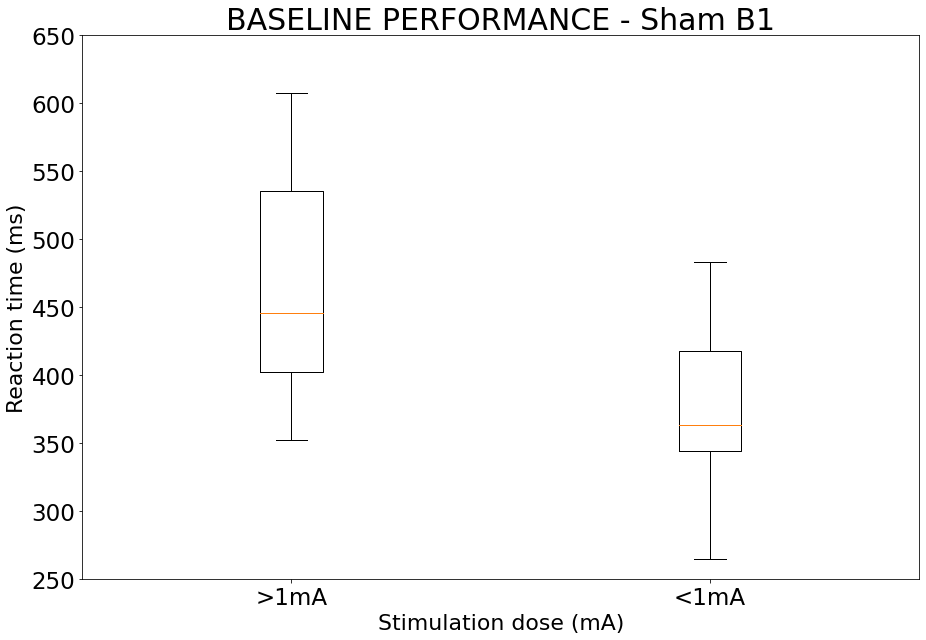

In [44]:
# fig = plt.figure(figsize=(15,10))
fig,ax = plt.subplots(figsize = ((15,10)))
data_to_plot = [b1_sham_abs_gtr_1mA, b1_sham_abs_less_1mA]
plt.boxplot(data_to_plot)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = '<1mA'
labels[0] = '>1mA'
ax.set_xticklabels(labels)
plt.ylim(250,650)
plt.rc('xtick', labelsize=23) 
plt.rc('ytick', labelsize=23) 
plt.rc('axes', titlesize=30)   
plt.rc('axes', labelsize=22)
plt.xlabel('Stimulation dose (mA)')
plt.ylabel('Reaction time (ms)')
plt.title('BASELINE PERFORMANCE - Sham B1')
plt.show()
fig.savefig('E:\\new_figures\\baseline.jpg')

In [29]:
learn_cond = anova_learn.groupby('condition')['learning'].apply(list).to_dict()
learn_cond_nn = anova_learn.groupby('condition')['learning_nn'].apply(list).to_dict()
er_ = an_file.groupby('block')['er'].apply(list).to_dict()
# learn_cond.set_index("condition")
anova_learn.set_index("Subject",drop = "index", inplace = True)
anova_learn.sort_index(inplace = True)
# anova_learn.to_csv(r"E:/rajat/laptop_files/dissertation/SRTT_CSV/anova_learn.csv")

In [ ]:
ind_df_nRT = pd.DataFrame()
ind_df_nRT = data_files_full['srtt_ind']
# ind_df_nRT.to_csv(r'E:/rajat/laptop_files/dissertation/SRTT_CSV/ind_df_nRT.csv')

In [ ]:
pg.wilcoxon(learn_cond['srtt_ind'], learn_cond['srtt_sham'], alternative='two-sided')


subjectwise - block rxn time - learning curve

1 norm_SUBC3FP2003_3
2 norm_SUBC3FP2008_2


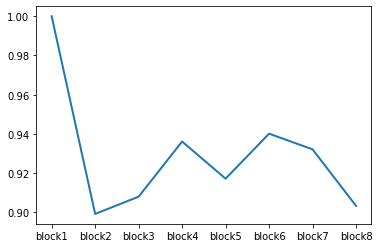

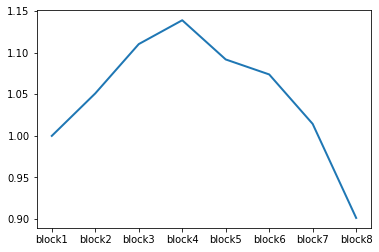

In [5]:
markers = ['o','s','^']
for i in range(0, len(outliers)):
    plt.figure()
    ax = data_files_full["srtt_ind"].iloc[:, i].plot(linewidth = 2)
    print(i+1, data_files_full["srtt_ind"].columns[i])
    

In [ ]:
##### normality learn

In [ ]:
## plot block norm cent 
markers = ['o','s','^']
ax = block_std.plot(linewidth = 2)


norm_cent change plot

AttributeError: 'str' object has no attribute 'view'

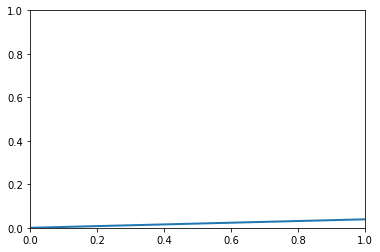

In [6]:
## plot block  
markers = ['o','s','^']
ax = block_norm_cent_mean.plot(yerr = block_norm_cent_err,  rot = 25, capsize = 5, linewidth = 2)


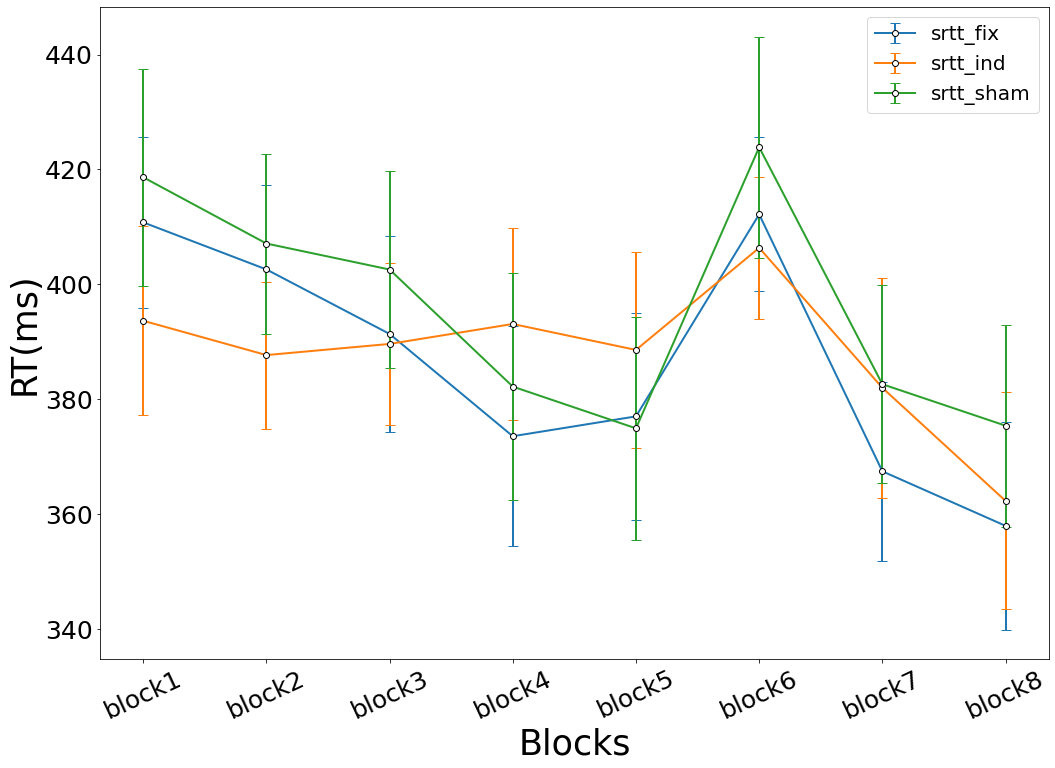

In [4]:
## abs rt
markers = ['o','s','^']
ax = block_rt_abs_mean.plot(yerr = block_rt_abs_er, figsize = (17,12), rot = 25, capsize = 5, linewidth = 2, marker = 'o', markeredgecolor = 'black', markerfacecolor = 'white' )

plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.rc('axes', titlesize=35)   
plt.rc('axes', labelsize=35) 
plt.ylabel("RT(ms)")
plt.xlabel("Blocks")
plt.legend( prop = {'size':20} )
plt.savefig(r'E:\new_figures\rt_block_21.jpeg')

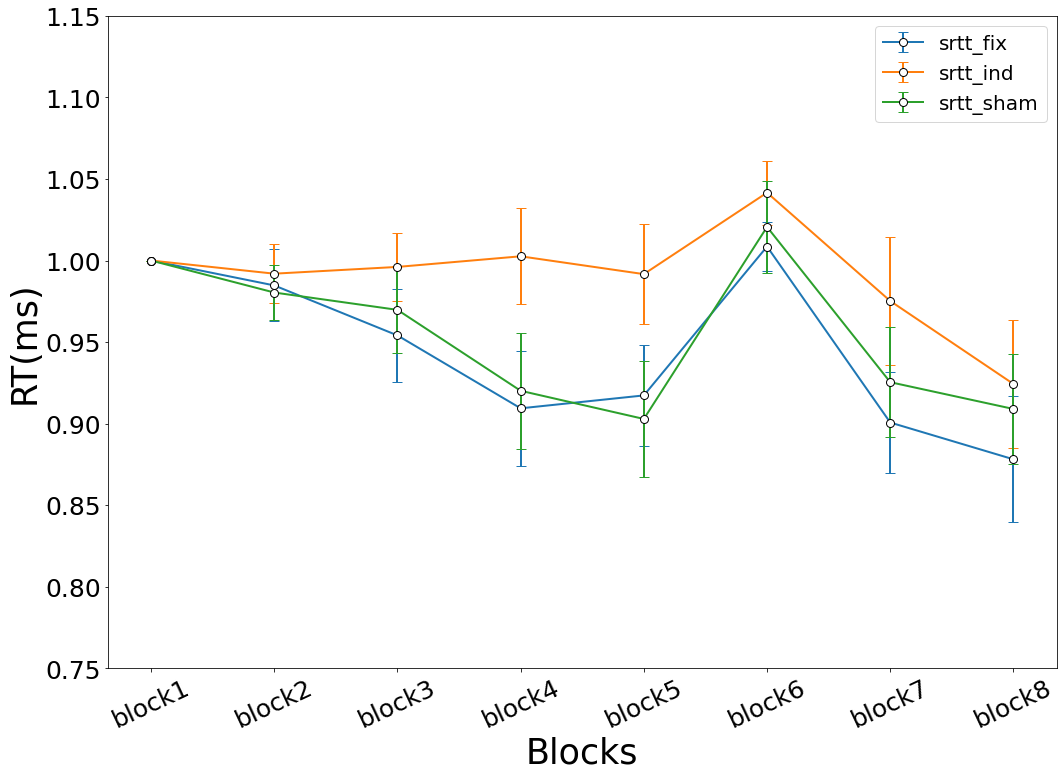

In [5]:
## blockwise performance with sem as error bars

block_mean.plot(yerr = block_err, ylim = [0.75,1.15], rot = 25, capsize = 5, linewidth = 2, figsize = (17,12), marker = 'o', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'white')
plt.ylabel("normalised RT")
plt.xlabel("Blocks")
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.rc('axes', titlesize=35)   
plt.rc('axes', labelsize=35) 
plt.ylabel("RT(ms)")
plt.xlabel("Blocks")
plt.legend( prop = {'size':20} )
plt.savefig(r'E:\new_figures\BLOCKrt21.jpg')

In [ ]:
## blockwise performance with sem as error bars
ax = block_er_mean.plot(yerr = block_er_sem, rot = 25, capsize = 5, linewidth = 2)

box plots-  for each condition

In [ ]:
block_idx = dict(zip(list(data_files_full['srtt_fix'].index.values), [i for i in range(1, 9)]))
fig, axes = plt.subplots(figsize = (20,25), nrows=3, ncols=1)
plt.ylabel('Normalised RT')
for ind, key in enumerate(data_files_full):
    axes[ind].set_title(key)
    axes[ind].set_ylim([0.4,1.4])
    
    # for index, row in data_files_full[key].iterrows():
        
    #     for indexx,i in row.iteritems():
    #         if (i < lower_bound[key][index]) or (i > upper_bound[key][index]):
    #             axes[ind].text(block_idx[index] + 0.1,i, indexx[-4:-2], ha = 'left', va = 'center')
                
    #axes[ind].text(0,1.2,'subject', ha = 'left', va = 'center')
    data_files_full[key].T.boxplot(ax = axes[ind], rot = 25)
   
plt.xlabel('Blocks')



In [ ]:
#fig.savefig('/home/friction_15/lab/dissertation/stats/box_block.jpg')

In [ ]:
dfff = pd.DataFrame()
dfff['mean'] = block_mean[filepaths].apply(lambda row: '_'.join(row.values.astype(str)), axis = 0)


In [ ]:
#t test between blocks
ttest_dict_56 = dict()
ttest_dict_68 = dict()
for key in data_files:
    ttest_dict_56[key] = ttest_ind(data_files_absRT[key]['block6'], data_files_absRT[key]['block5'])
    ttest_dict_68[key] = ttest_ind(data_files_absRT[key]['block6'], data_files_absRT[key]['block8'])

In [ ]:
for key in ttest_dict_56:
    print('5-6',key, ttest_dict_56[key])
    print('6-8', key, ttest_dict_68[key])

In [ ]:
#t test between blocks
ttest_dict_56 = dict()
ttest_dict_68 = dict()
for key in data_files:
    ttest_dict_56[key] = ttest_ind(data_files[key]['block6'], data_files[key]['block5'])
    ttest_dict_68[key] = ttest_ind(data_files[key]['block6'], data_files[key]['block8'])

In [ ]:
for key in ttest_dict_56:
    print('5-6',key, ttest_dict_56[key])
    print('6-8', key, ttest_dict_68[key])

z- score

In [22]:
# inter subject z- score
for key in data_files_full:
    mean_block_1 = data_files_full[key].loc["block2"].mean()
    z_score = (data_files_full[key].T - data_files_full[key].T.mean()) / data_files_full[key].T.std()
    std_blockwise = data_files_full[key].std(axis = 1)
    fig = px.strip(z_score, hover_name = z_score.index.str[-4:-2])
    fig.show()

In [23]:
#test for normality - shapiro wilk test
for blocks in data_files_full:
    normality_full, p_val = shapiro(data_files_full[blocks])
    print(blocks, "test_stat- ", normality_full, "p_value- ", p_val )

srtt_fix test_stat-  0.8596615195274353 p_value-  1.098451957659563e-05
srtt_ind test_stat-  0.9520483613014221 p_value-  0.026283882558345795
srtt_sham test_stat-  0.8740077614784241 p_value-  3.0056260584387928e-05


c:\Users\PC01\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1758: UserWarning:

Input data for shapiro has range zero. The results may not be accurate.



srtt_fix block1 :  test_stat -  1.0 p-value -  1.0
srtt_fix block2 :  test_stat -  0.9297487139701843 p-value -  0.5487640500068665
srtt_fix block3 :  test_stat -  0.8540583848953247 p-value -  0.13382220268249512
srtt_fix block4 :  test_stat -  0.8487401008605957 p-value -  0.11967834085226059
srtt_fix block5 :  test_stat -  0.8250062465667725 p-value -  0.07172427326440811
srtt_fix block6 :  test_stat -  0.7813392877578735 p-value -  0.026649946346879005
srtt_fix block7 :  test_stat -  0.8335220813751221 p-value -  0.08639409393072128
srtt_fix block8 :  test_stat -  0.8411992788314819 p-value -  0.10194547474384308
srtt_ind block1 :  test_stat -  1.0 p-value -  1.0
srtt_ind block2 :  test_stat -  0.961193323135376 p-value -  0.8289052248001099
srtt_ind block3 :  test_stat -  0.9398117065429688 p-value -  0.6370241045951843
srtt_ind block4 :  test_stat -  0.9467077255249023 p-value -  0.6996663212776184
srtt_ind block5 :  test_stat -  0.9320091605186462 p-value -  0.5681141018867493
s

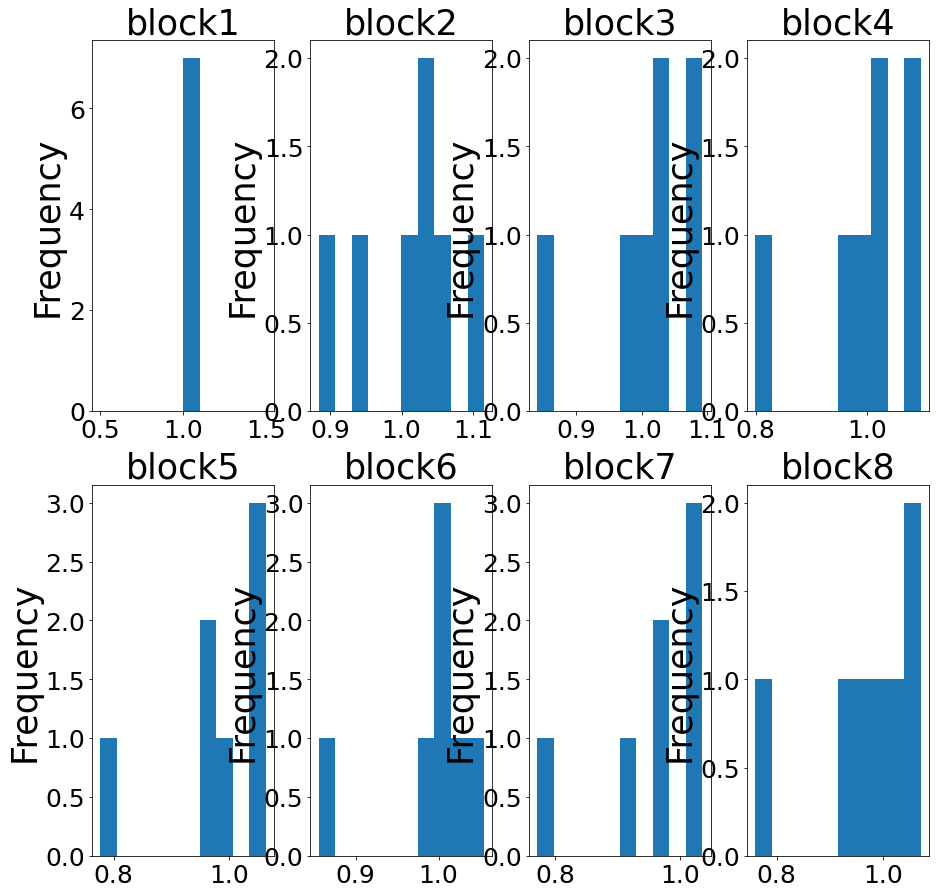

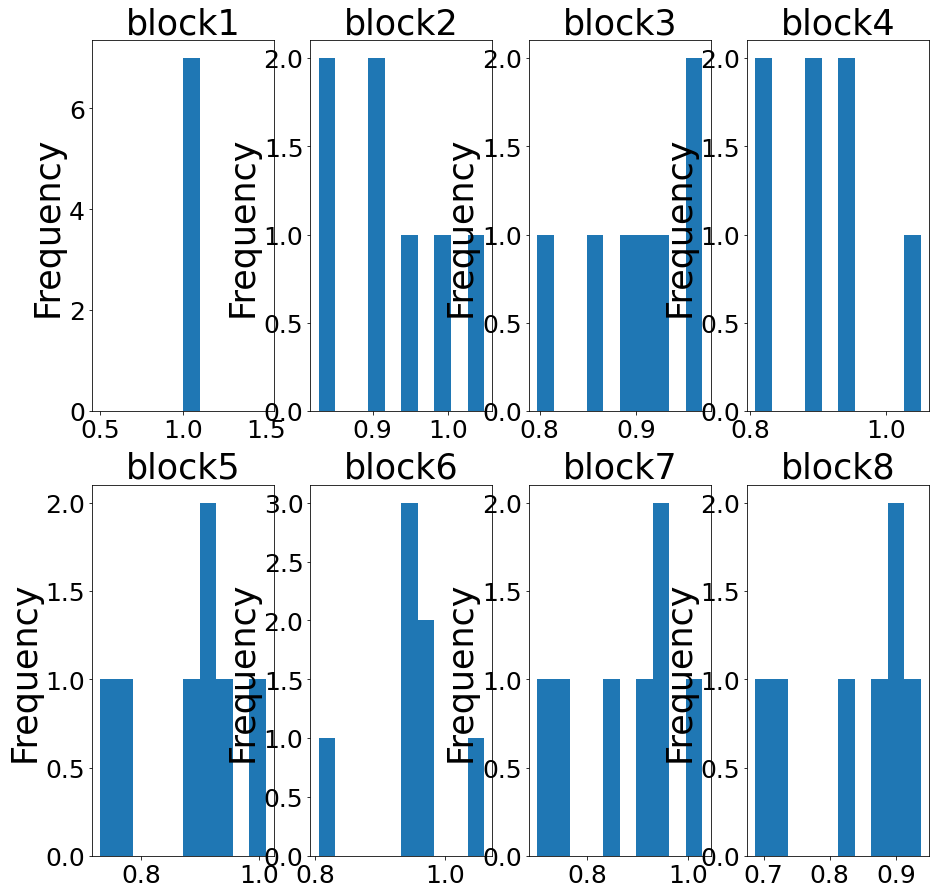

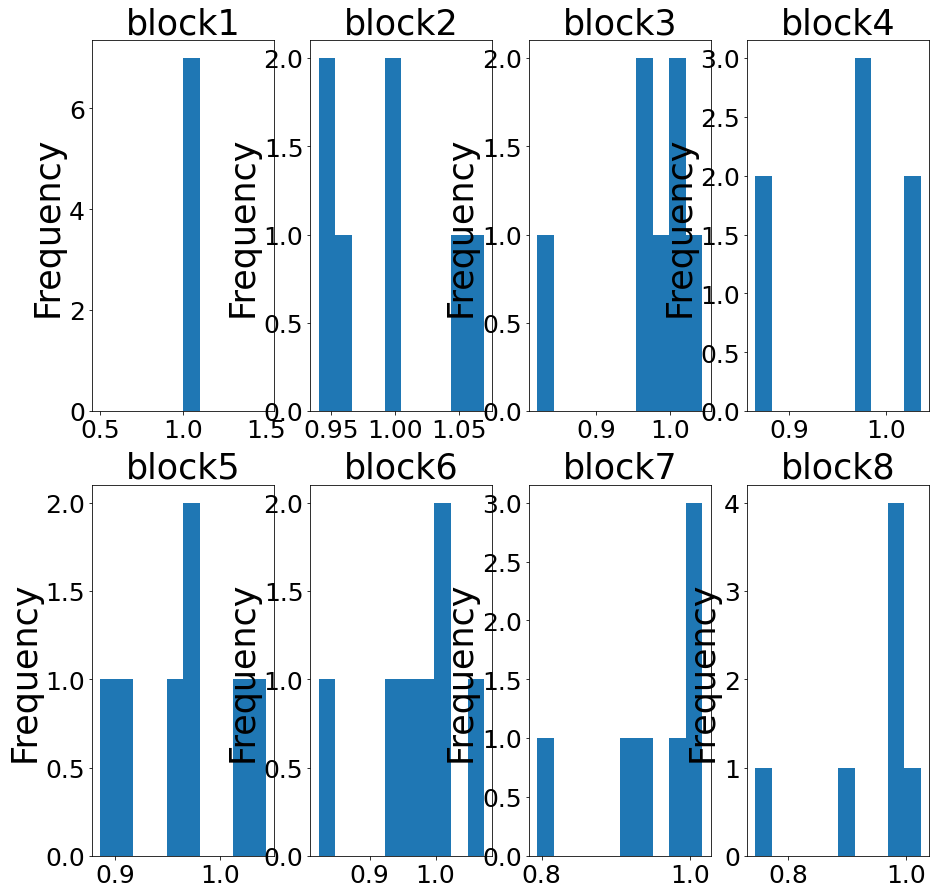

In [24]:
## TEST FOR NORMALITY
# saphiro wilk test
fig1, axis1 = plt.subplots(2,4,figsize=(15, 15))
fig2, axis2 = plt.subplots(2,4,figsize=(15, 15))
fig3, axis3 = plt.subplots(2,4,figsize=(15, 15))
axis = [axis1,axis2,axis3]
for ind, blocks in enumerate(data_files_abs):
    k = 0
    i = 0
    j = 0
    for index, row in data_files_full[blocks].iterrows():
        normality_rt, p = shapiro(row)
        print(blocks,index, ': ', 'test_stat - ', normality_rt, 'p-value - ',p)
        row.plot.hist(ax = axis[ind][i,j], title = index)
        k += 1
        j = k%4
        if k>3:
            i = 1

In [25]:
# normality block_mean
normality_rt_mean, p_mean = shapiro(block_mean)
print('test_stat - ', normality_rt_mean, ';','p_value - ',p_mean)

test_stat -  0.9117134213447571 ; p_value -  0.03842718154191971


In [26]:
#normaity and variance across condition ( rt_means)
for key in block_mean:
    normality_cond, p_cond = shapiro(block_mean[key])
    var = stat.variance(block_mean[key])
    print(key, '-', 'test_stat - ', normality_cond, ';','p_value - ',p_cond)
    print(key, 'variance', ';', var)
    # plt.figure()
    # plt.hist(block_mean[key])

var_stat, var_p = levene(block_mean.loc[:, 'srtt_fix'], block_mean.loc[:, 'srtt_ind'], block_mean.loc[:, 'srtt_sham'])
print('/n', var_stat, var_p)

srtt_fix - test_stat -  0.9599876403808594 ; p_value -  0.8099822998046875
srtt_fix variance ; 0.0004088224630482289
srtt_ind - test_stat -  0.980061411857605 ; p_value -  0.963207483291626
srtt_ind variance ; 0.0024792462535653333
srtt_sham - test_stat -  0.9486553072929382 ; p_value -  0.6976656317710876
srtt_sham variance ; 0.00037241553407396015
/n 2.636313989659466 0.09517341964106045


In [ ]:
#normality check rt_norm
data_rt_norm = data_files_abs['srtt_ind']
for i in range(11):
    # norm, p = shapiro(data_rt_norm.iloc[i]) # blockwise ( 1*block x 23*sub ) 
    
    norm, p = shapiro(data_rt_norm.T.iloc[i]) # subjectwise per condition (1*sub x 8*blocks)
    print(norm, p)


In [ ]:
### normality check ER
for i in range(20):
    norm , p = shapiro(final_er.T.iloc[i])
    print(norm, p)

ANOVA

In [30]:
# # ## using pg
aov_norm = pg.rm_anova(dv = "norm_rt", within = ['block', 'condition'], subject = 'subject', data = an_file)
pg.print_table(aov_norm)

# sphr = pg.sphericity(an_file, dv = 'norm_rt', method= "shapiro", alpha=0.05 )
# sphr
# aov_rt_abs = pg.rm_anova(dv = "rt_abs", within = ['block', 'condition'], subject = 'subject', data = an_file)
# pg.print_table(aov_rt_abs)

# aov_er = pg.rm_anova(dv = "er", within = ['block', 'condition'], subject = 'subject', data = an_file)
# pg.print_table(aov_er)

# aov_var = pg.rm_anova(dv = "var", within = ['block', 'condition'], subject = 'subject', data = an_file)
# pg.print_table(aov_var)

# aov_norm_CENT = pg.rm_anova(dv = "norm_cent", within = ['block', 'condition'], subject = 'subject', data = an_file)
# pg.print_table(aov_norm_CENT)

# aov_learn = pg.friedman(learn_cond)
# pg.print_table(aov_learn)

# fmc(learn_cond_nn["srtt_fix"], learn_cond_nn["srtt_ind"], learn_cond_nn["srtt_sham"])
# aov_learn = pg.kruskal(data = anova_learn, dv = 'learning_nn', between = "condition")
# pg.print_table(aov_learn)


ANOVA SUMMARY

Source                SS    ddof1    ddof2     MS      F    p-unc    p-GG-corr    np2    eps
-----------------  -----  -------  -------  -----  -----  -------  -----------  -----  -----
block              0.109        7       42  0.016  4.714    0.001        0.029  0.440  0.297
condition          0.192        2       12  0.096  6.931    0.010        0.030  0.536  0.595
block * condition  0.050       14       84  0.004  2.880    0.001        0.102  0.324  0.131



c:\Users\PC01\AppData\Local\Programs\Python\Python39\lib\site-packages\pingouin\distribution.py:485: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



post-hoc

In [33]:
ttest = pg.pairwise_ttests(dv = "norm_rt", within = ['block'], subject = 'subject' , parametric = False, data = an_file, padjust="bonf", return_desc=False)
ttest


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,block,block1,block2,True,False,7.0,two-sided,0.296875,1.0000,bonf,0.547798
1,block,block1,block3,True,False,5.0,two-sided,0.156250,1.0000,bonf,0.741531
2,block,block1,block4,True,False,5.0,two-sided,0.156250,1.0000,bonf,0.848037
3,block,block1,block5,True,False,1.0,two-sided,0.031250,0.8750,bonf,1.143179
4,block,block1,block6,True,False,5.0,two-sided,0.156250,1.0000,bonf,0.740583
5,block,block1,block7,True,False,0.0,two-sided,0.015625,0.4375,bonf,1.164198
6,block,block1,block8,True,False,0.0,two-sided,0.015625,0.4375,bonf,1.272397
7,block,block2,block3,True,False,7.0,two-sided,0.296875,1.0000,bonf,0.238692
8,block,block2,block4,True,False,2.0,two-sided,0.046875,1.0000,bonf,0.337440
9,block,block2,block5,True,False,0.0,two-sided,0.015625,0.4375,bonf,0.560733


In [34]:
p_vals = ttest['p-unc'].to_list()
r, j = pg.multicomp(p_vals, method='bonf')
print(r,j)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False] [1.     1.     1.     0.875  1.     0.4375 0.4375 1.     1.     0.4375
 1.     0.4375 0.875  1.     0.875  1.     1.     0.875  1.     1.
 1.     1.     1.     1.     1.     1.     0.4375 1.    ]


BASELINE - ONE WAY ANOVA

In [ ]:
# creating a data frame
df_b1 = pd.DataFrame()

df_b1["fix"] = data_files_abs["srtt_fix"].loc["block1"]
df_b1["ind"] = data_files_abs["srtt_ind"].loc["block1"].to_numpy() 
df_b1["sham"] = data_files_abs["srtt_sham"].loc["block1"].to_numpy()
df_b1["respID"] = range(1, len(df_b1) + 1)
df_b1.head()

In [ ]:
longDF_b1 = pd.melt(df_b1, id_vars = 'respID', var_name = 'cond', value_name = 'absRT')
longDF_b1.head()

In [ ]:
#anova
an_b1 = pg.friedman(data = longDF_b1, dv = "absRT", within = "cond", subject = "respID")
print(an_b1)
# an_b1.to_csv(r'E:/rajat/laptop_files/dissertation/SRTT_CSV/baseline_friedman_anova.csv', index=False)

BLOCK 5 ONE WAY ANOVA

In [ ]:
#creating a data frame
df_b5 = pd.DataFrame()

df_b5["fix"] = data_files_abs["srtt_fix"].loc["block5"].to_numpy()
df_b5["ind"] = data_files_abs["srtt_ind"].loc["block5"].to_numpy() 
df_b5["sham"] = data_files_abs["srtt_sham"].loc["block5"].to_numpy()
df_b5["respID"] = range(1, len(df_b5) + 1)
df_b5.head()

In [ ]:
#anova
longDF_b5 = pd.melt(df_b5, id_vars = 'respID', var_name = 'cond', value_name = 'absRT')
longDF_b5.head()

In [ ]:
an_b5 = pg.friedman(data = longDF_b5, dv = "absRT", within = "cond", subject = "respID")
print(an_b5)


PLOTTING LEARNING HISTOGRAM

In [ ]:
plt.figure()
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(learn_cond_nn["srtt_fix"])
ax.set_xlabel = "Block6 - Block 5"
ax.set_ylabel = "Frequency"

 

In [ ]:
plt.figure()
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(learn_cond_nn["srtt_ind"])
ax.set_xlabel = "Block6 - Block 5"
ax.set_ylabel = "Frequency"

In [ ]:
plt.figure()
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(learn_cond_nn["srtt_sham"])
ax.set_xlabel = "Block6 - Block 5"
ax.set_ylabel = "Frequency"

T-TEST NORMALISED RT BLOCK 1

In [ ]:
fix_b1 = np.array(data_files_abs['srtt_fix'].iloc[0]).astype(float)
ind_b1 = np.array(data_files_abs['srtt_ind'].iloc[0]).astype(float)
sham_b1 = np.array(data_files_abs['srtt_sham'].iloc[0]).astype(float)



In [ ]:
pg.wilcoxon(sham_b1.T.tolist(), ind_b1.T.tolist(), alternative='two-sided')


In [ ]:
pg.wilcoxon(fix_b1.T.tolist(), sham_b1.T.tolist(), alternative='two-sided')

In [ ]:
type(fix_b1)

Annoting asterix

In [ ]:
final_VAR_file['srtt_fix']

In [ ]:
cond_variability = pd.DataFrame(index=blocks)
cond_variability["fix"] = final_VAR_file['srtt_fix'].mean(axis=1)    
cond_variability["ind"] = final_VAR_file['srtt_ind'].mean(axis=1)
cond_variability["sham"] = final_VAR_file['srtt_sham'].mean(axis=1)
# cond_variability.to_csv(r"E:\rajat\laptop_files\dissertation\SRTT_CSV\cond_variability.csv")

Violin Plots

In [7]:
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

In [ ]:
data_to_plot = [cond_variability['fix'], cond_variability['ind'], cond_variability['sham'] ]

fig = plt.figure(figsize=(12, 7))

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = ax.violinplot(data_to_plot, showmeans=False, showmedians=False, showextrema=True)
labels = ['Fix', 'Ind', 'Sham']
for ax in [ax]:
    set_axis_style(ax, labels)
ax.set_xlabel('Stimulation Condition')
ax.set_ylabel('Variability form mean')
ax.set_title('Variability across Conditions')

for pc in bp['bodies']:
    pc.set_facecolor('#E6E6FA')
    pc.set_edgecolor('#F0F8FF')
    pc.set_alpha(1)
quartile1, medians, quartile3 = np.percentile(data_to_plot, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data_to_plot, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 0]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
plt.show()
# plt.xlabel('tDCS conditions')
# plt.ylabel('frequency')

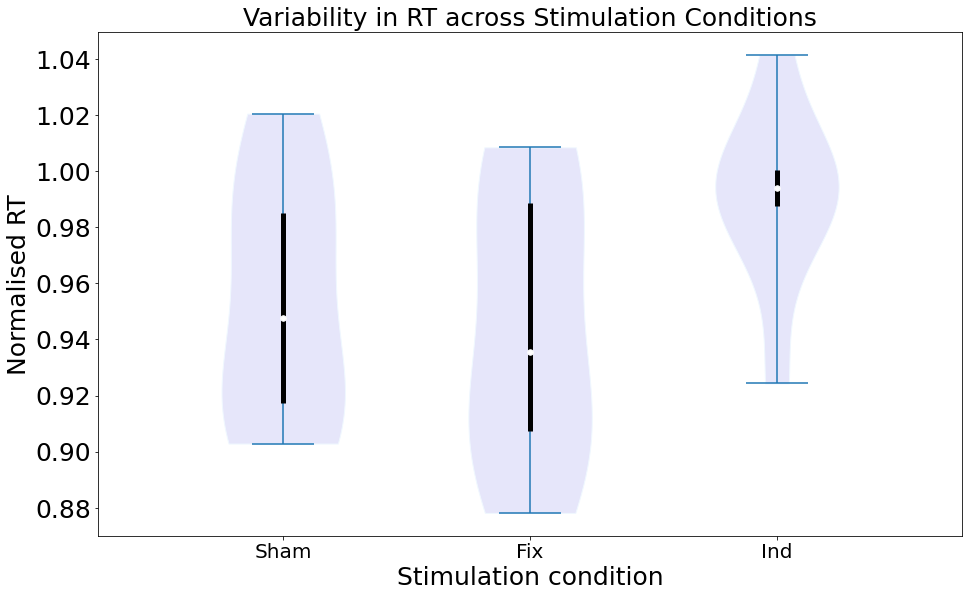

In [8]:
data_to_plot = [data_files_full['srtt_sham'].mean(axis=1), data_files_full['srtt_fix'].mean(axis=1), data_files_full['srtt_ind'].mean(axis=1)]

fig = plt.figure(figsize=(12, 7))

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = ax.violinplot(data_to_plot, showmeans=False, showmedians=False, showextrema=True)
labels = ['Sham', 'Fix', 'Ind']
for ax in [ax]:
    set_axis_style(ax, labels)
ax.set_xlabel('Stimulation condition')
ax.set_ylabel('Normalised RT')
ax.set_title('Variability in RT across Stimulation Conditions')

plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22) 
plt.rc('ytick', labelsize=25) 
plt.rc('axes', titlesize=25)   
plt.rc('axes', labelsize=25)  


for pc in bp['bodies']:
    pc.set_facecolor('#E6E6FA')
    pc.set_edgecolor('#F0F8FF')
    pc.set_alpha(1)
quartile1, medians, quartile3 = np.percentile(data_to_plot, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data_to_plot, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 0]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
plt.show()
# plt.xlabel('tDCS conditions')
# plt.ylabel('frequency')

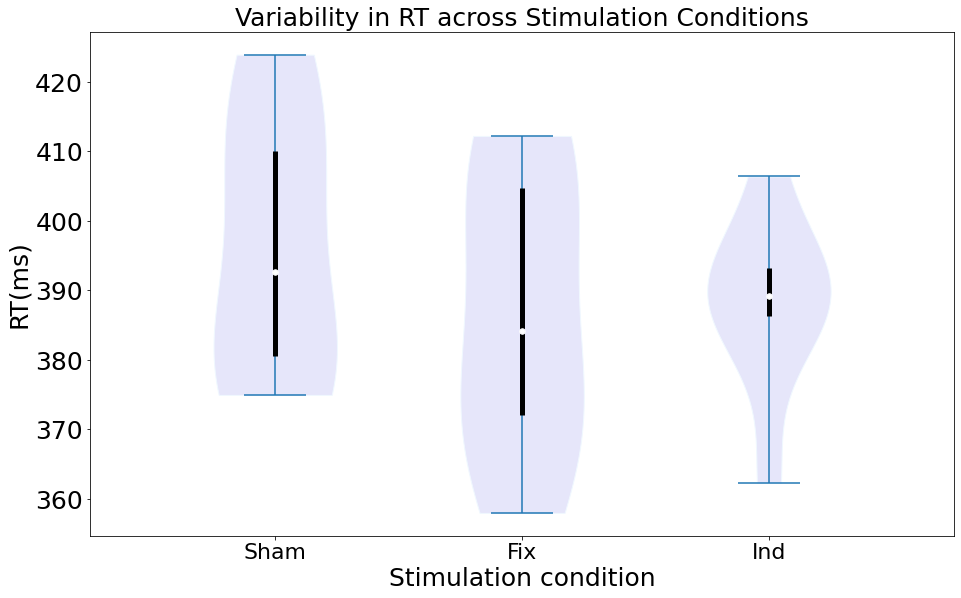

In [9]:
data_to_plot = [data_files_abs['srtt_sham'].mean(axis=1), data_files_abs['srtt_fix'].mean(axis=1), data_files_abs['srtt_ind'].mean(axis=1)  ]
fig = plt.figure(figsize=(12,7))

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = ax.violinplot(data_to_plot, showmeans=False, showmedians=False, showextrema=True)
labels = ['Sham', 'Fix', 'Ind']
for ax in [ax]:
    set_axis_style(ax, labels)
ax.set_xlabel('Stimulation condition')
ax.set_ylabel('RT(ms)')
ax.set_title('Variability in RT across Stimulation Conditions')

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('axes', titlesize=20)   
plt.rc('axes', labelsize=20)  

for pc in bp['bodies']:
    pc.set_facecolor('#E6E6FA')
    pc.set_edgecolor('#F0F8FF')
    pc.set_alpha(1)
quartile1, medians, quartile3 = np.percentile(data_to_plot, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data_to_plot, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 0]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)



plt.show()
# plt.xlabel('tDCS conditions')
# plt.ylabel('frequency')

In [1]:
efi_fix = [0.1290872509,
0.1190665614,
0.1327052083,
0.1456209667,
0.09277461825,
0.132145054,
0.1123129784,
0.1036242662,
0.07868286882,
0.1242115855,
0.1133494396,
0.06101916335,
0.1170137704,
0.1018251941,
0.07543635235,
0.1180438371,
0.1120223956,
0.115634428,
0.1537369518,
0.1191232299,
0.1107131864,
0.1372999038,
0.1060839945]

efi_ind = [0.1123940073,
0.112916551,
0.1156350355,
0.1118093424,
0.1148628346,
0.1139284334,
0.1137476429,
0.1135994881,
0.1134547322,
0.1147165177,
0.110058593,
0.113048365,
0.1151760159,
0.1164102517,
0.1128513557,
0.1130714322,
0.1132001911,
0.1143589767,
0.1131393518,
0.1122743109,
0.1135313387,
0.1133725938,
0.1139431472] 



In [ ]:
fig = plt.figure(figsize = (15,10))
ax = sns.histplot(efi_fix, color = '#E6E6FA' , line_kws={'color':'black'})
sns.kdeplot(efi_fix)
ax = sns.histplot(efi_ind, color = 'black' , line_kws={'color':'black'})

In [ ]:
data_to_plot = [efi_fix, efi_ind]
fig = plt.figure(figsize=(12,7))

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = ax.violinplot(data_to_plot, showmeans=False, showmedians=False, showextrema=True)
labels = ['Fix', 'Ind']
for ax in [ax]:
    set_axis_style(ax, labels)

ax.set_xlabel('Stimulation condition')
ax.set_ylabel('Electric Field Intensity (V/m)')
ax.set_title('Variability in Electric Field Intensity (V/m)')

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('axes', titlesize=20)   
plt.rc('axes', labelsize=20)  

for pc in bp['bodies']:
    pc.set_facecolor('#E6E6FA')
    pc.set_edgecolor('#F0F8FF')
    pc.set_alpha(1)
quartile1, medians, quartile3 = np.percentile(data_to_plot, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data_to_plot, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 0]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)



TACS

In [ ]:
fix_f4 = [0.2556534602,
0.1387080942,
0.1712992236,
0.1230553508,
0.107272598,
0.1011102499,
0.107163073,
0.1084992582,
0.1357069147,
0.1103130614,
0.1118159439,
0.09213208172,
0.1490151649,
0.1316998589,
0.1160863311,
0.1219518711,
0.1050606504,
0.1433699483,
0.1072849233,
0.0915648595,
0.2196776675,
0.1315689096,
0.1585158973,
0.107754976,
0.1411731047,
0.1111957157,
0.1390179684,
0.1080771027,
0.1238181466,
0.157740781,
0.1044576045,
0.1327891263,
0.1061480609,
0.08057381506,
0.1037279524,
0.1069742653]

fix_p4 = [0.08679977872,
0.1082479402,
0.07528648915,
0.0900782697,
0.09015936735,
0.09115056479,
0.05670561446,
0.1124199835,
0.0781793142,
0.0725557018,
0.08371525601,
0.08688424991,
0.1036554713,
0.1609374855,
0.1295581696,
0.08042005969,
0.09187480934,
0.122512936,
0.1233493227,
0.1059191357,
0.08399131459,
0.09418436319,
0.08322284878,
0.08488271471,
0.1133139721,
0.07825017823,
0.09158080519,
0.1063457429,
0.09520596565,
0.1102850485,
0.1207570899,
0.1364079293,
0.09103993778,
0.08359401449,
0.08424767171,
0.07862907366]

ind_f4 = [0.1276208988,
0.1088977501,
0.1184411775,
0.1256639847,
0.1573375953,
0.1512149071,
0.1391108506,
0.1712063496,
0.1184470171,
0.1218876776,
0.1149917683,
0.1322779966,
0.08862967286,
0.119791945,
0.1195224338,
0.1279008752,
0.1278458334,
0.1364693883,
0.1290340608,
0.1865190591,
0.121848485,
0.1199548701,
0.1073592894,
0.1270083174,
0.1053932461,
0.1215834211,
0.1169546625,
0.1391722716,
0.1135788374,
0.1153457297,
0.1205894499,
0.1355351973,
0.1542345032,
0.1389603851,
0.1295467043,
0.1183616439]

ind_p4 = [0.1348900192,
0.1510756251,
0.1402010953,
0.1550156868,
0.1756311397,
0.1919581164,
0.1282252381,
0.2115343658,
0.1480006075,
0.1385750022,
0.1543964412,
0.1915766063,
0.1413535992,
0.2287626936,
0.229581136,
0.1377995269,
0.19298815,
0.1637925665,
0.2417684882,
0.2377944209,
0.138230358,
0.1518139149,
0.1379415904,
0.1659406779,
0.1564082342,
0.1515664492,
0.1326855258,
0.1992796704,
0.1526757816,
0.1452892271,
0.2268846137,
0.1984633261,
0.1736685591,
0.2142647734,
0.1685033662,
0.1484203922]

In [ ]:
efi_tacs = pd.DataFrame()
efi_tacs['fix_f4'] = fix_f4
efi_tacs['ind_f4'] = ind_f4
efi_tacs['fix_p4'] = fix_p4
efi_tacs['ind_p4'] = ind_p4

In [ ]:
fig = plt.figure(figsize =(15,10))
ax = fig.add_axes([0,0,1,1])
bp = ax.violinplot(data_to_plot,positions= [1,1.5,3,3.5], showmeans=False, showmedians=False, showextrema=True)
ax.set_xticks([1,1.5,3,3.5])
ax.set_xticklabels(['Fix_F4', 'Ind_F4', 'Fix_P4', 'Ind_P4' ])
ax.set_xlabel('Stimulation condition')
ax.set_ylabel('Electric Field Intensity (V/m)')
ax.set_title('Variability in Electric Field Intensity (V/m)')

for pc in bp['bodies']:
    pc.set_facecolor('#E6E6FA')
    pc.set_edgecolor('#F0F8FF')
    pc.set_alpha(1)


    
quartile1, medians, quartile3 = np.percentile(data_to_plot, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data_to_plot, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 0]

inds = [[1,1.5,3,3.5]]
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

In [ ]:
ind_dose_tacs = [1.011795136,
1.015886363,
1.166525295,
1.145107957,
1.313584867,
1.393643686,
1.548763641,
1.298733869,
1.123361017,
1.277379664,
1.260210811,
1.529452702,
0.9456196045,
1.069945424,
1.213852312,
1.155469449,
1.341241091,
0.9828535409,
1.313433957,
1.538927293,
1.045627091,
1.07101033,
1.055282236,
1.307704448,
0.9981480654,
1.267240023,
1.013621929,
1.303806799,
1.138053389,
0.8933115486,
1.348984231,
1.061168676,
1.32750104,
1.748851798,
1.358473373,
1.317248228]

In [ ]:
sns.distplot(ind_dose_tacs)

In [8]:
b1_RT_abs = pd.DataFrame()
b1_RT_abs['sham'] =data_files_abs['srtt_sham'].iloc[0].to_numpy()
b1_RT_abs['fix'] =data_files_abs['srtt_fix'].iloc[0].to_numpy()
b1_RT_abs['ind'] =data_files_abs['srtt_ind'].iloc[0].to_numpy()

C:\Users\PC01\AppData\Local\Temp\ipykernel_8856\2493669263.py:36: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "scale" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(r"E:\\rajat\python_plots\RT_at_block_1.jpg", scale = 15)


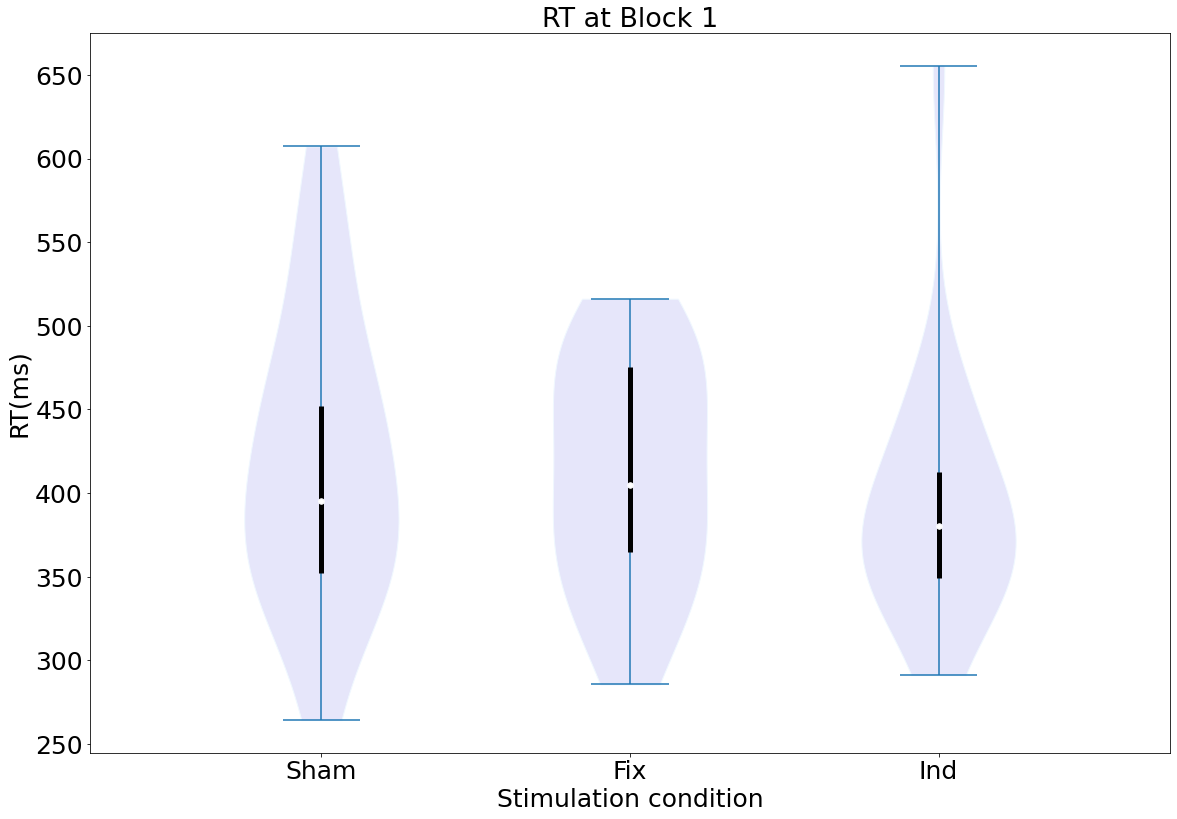

In [15]:
data_to_plot = [data_files_abs['srtt_sham'].iloc[0].to_numpy(), data_files_abs['srtt_fix'].iloc[0].to_numpy(), data_files_abs['srtt_ind'].iloc[0].to_numpy() ]
fig = plt.figure(figsize=(15,10))

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = ax.violinplot(data_to_plot, showmeans=False, showmedians=False, showextrema=True)
labels = ['Sham', 'Fix', 'Ind']
for ax in [ax]:
    set_axis_style(ax, labels)
ax.set_xlabel('Stimulation condition')
ax.set_ylabel('RT(ms)')
ax.set_title('RT at Block 1')

plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.rc('axes', titlesize=27)   
plt.rc('axes', labelsize=25)  

for pc in bp['bodies']:
    pc.set_facecolor('#E6E6FA')
    pc.set_edgecolor('#F0F8FF')
    pc.set_alpha(1)
quartile1, medians, quartile3 = np.percentile(data_to_plot, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data_to_plot, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 0]

inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# plt.savefig(r"E:\\rajat\python_plots\RT_at_block_1.jpg", scale = 15)
plt.show()
# plt.xlabel('tDCS conditions')
# plt.ylabel('frequency')

NameError: name 'set_axis_style' is not defined

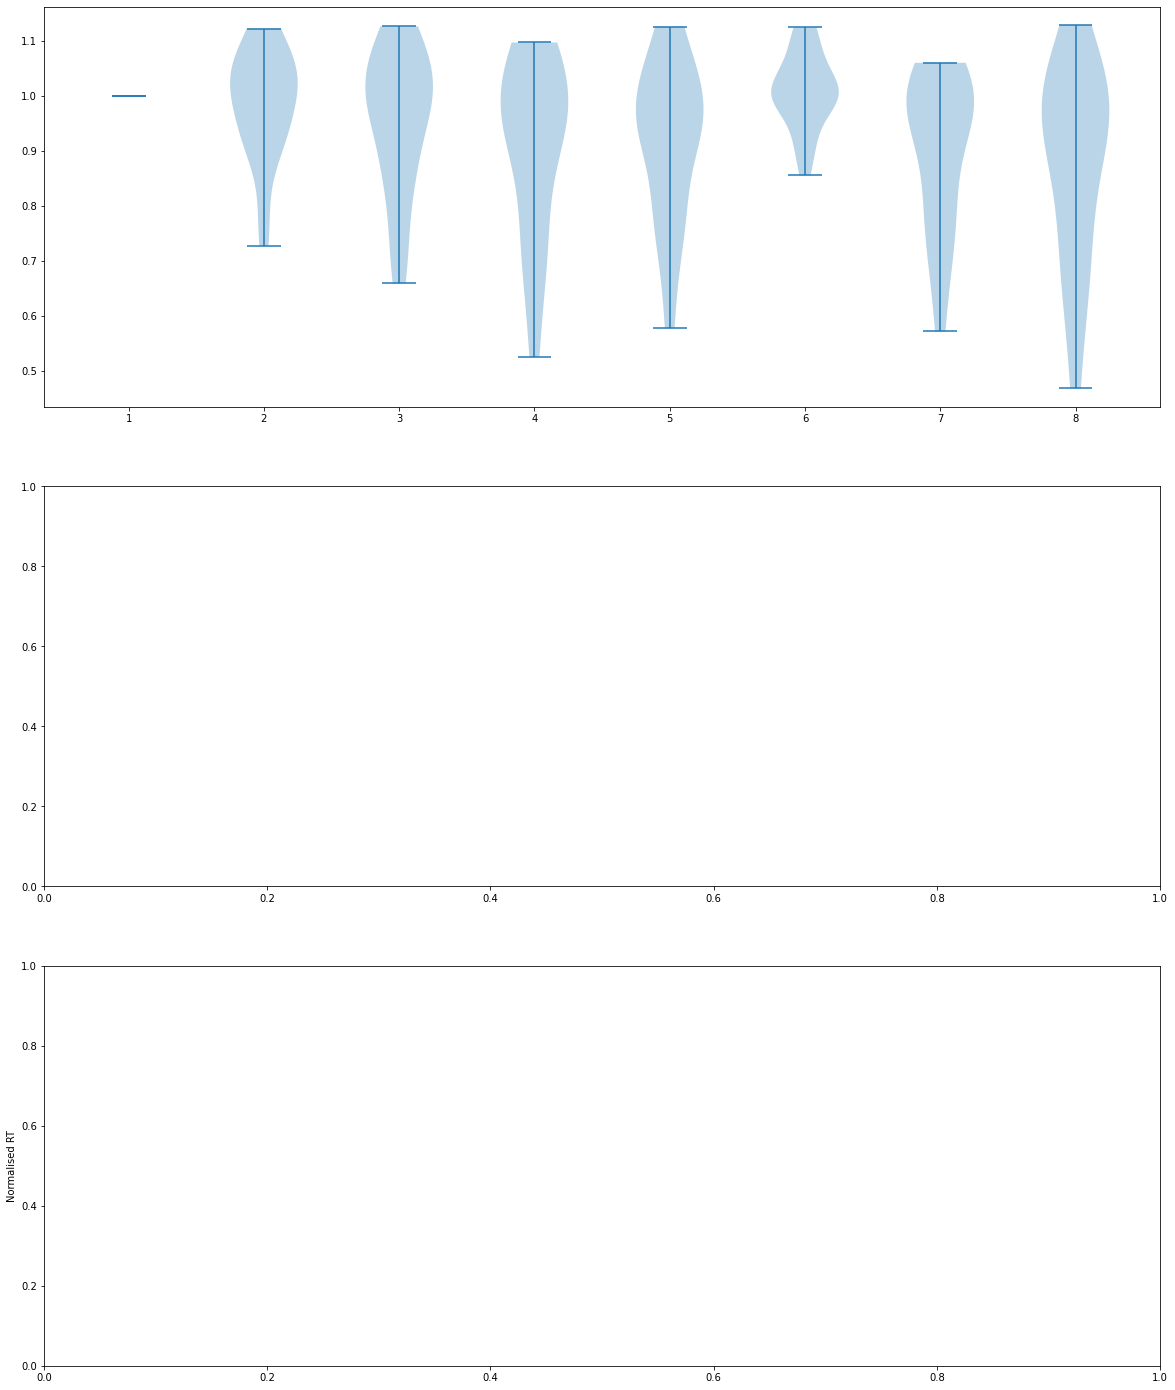

In [5]:
block_idx = dict(zip(list(data_files_full['srtt_fix'].index.values), [i for i in range(1, 9)]))
fig, axes = plt.subplots(figsize = (20,25), nrows=3, ncols=1)
plt.ylabel('Normalised RT')
for ind, key in enumerate(data_files_full):

    ax = axes[ind]

    # Create the boxplot
    bp = ax.violinplot(data_files_full[key].T, showmeans=False, showmedians=False, showextrema=True)
    labels = blocks
    for ax in [ax]:
        set_axis_style(ax, labels)
    ax.set_xlabel('')
    ax.set_ylabel('normalised RT')
    ax.set_title(key[5:])

    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=15) 
    plt.rc('axes', titlesize=35)   
    plt.rc('axes', labelsize=35)  

    for pc in bp['bodies']:
        pc.set_facecolor('#E6E6FA')
        pc.set_edgecolor('#F0F8FF')
        pc.set_alpha(1)
    quartile1, medians, quartile3 = np.percentile(data_files_full[key], [25, 50, 75], axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data_files_full[key].to_numpy(), quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 0]

    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

    #axes[ind].set_title(key)
    #axes[ind].set_ylim([0.4,1.4])
    
    # for index, row in data_files_full[key].iterrows():
        
    #     for indexx,i in row.iteritems():
    #         if (i < lower_bound[key][index]) or (i > upper_bound[key][index]):
    #             axes[ind].text(block_idx[index] + 0.1,i, indexx[-4:-2], ha = 'left', va = 'center')
                
    #axes[ind].text(0,1.2,'subject', ha = 'left', va = 'center')
    #data_files_full[key].T.boxplot(ax = axes[ind], rot = 25)




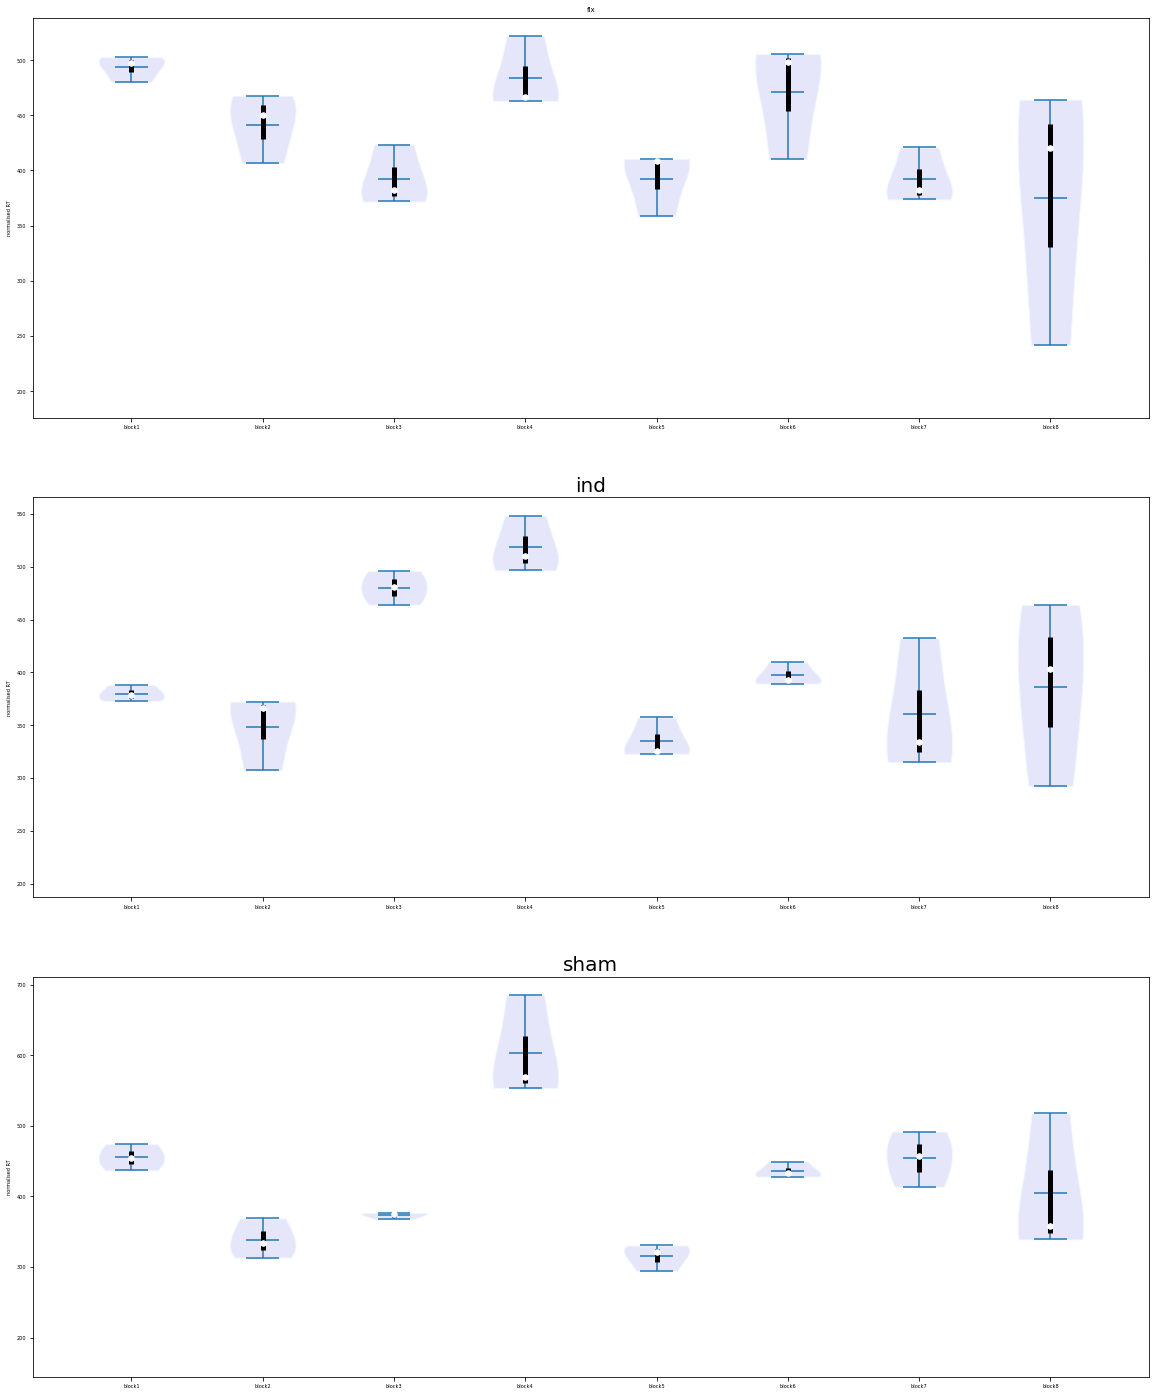

In [25]:
block_idx = dict(zip(list(data_files_absRT['srtt_fix'].index.values), [i for i in range(1, 9)]))
fig, axes = plt.subplots(figsize = (20,25), nrows=3, ncols=1)
plt.ylabel('RT (ms)')
for ind, key in enumerate(data_files_absRT):

    ax = axes[ind]

    # Create the boxplot
    bp = ax.violinplot(data_files_absRT[key].T, showmeans=True, showmedians=False, showextrema=True)
    labels = blocks
    for ax in [ax]:
        set_axis_style(ax, labels)
    ax.set_xlabel('')
    ax.set_ylabel('normalised RT')
    ax.set_title(key[5:])
    
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15) 
    plt.rc('ytick', labelsize=15) 
    plt.rc('axes', titlesize=20)   
    plt.rc('axes', labelsize=20)  

    for pc in bp['bodies']:
        pc.set_facecolor('#E6E6FA')
        pc.set_edgecolor('#F0F8FF')
        pc.set_alpha(1)
    quartile1, medians, quartile3 = np.percentile(data_files_absRT[key], [25, 50, 75], axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data_files_absRT[key].to_numpy(), quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 0]

    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

    #axes[ind].set_title(key)
    #axes[ind].set_ylim([0.4,1.4])
    
    # for index, row in data_files_full[key].iterrows():
        
    #     for indexx,i in row.iteritems():
    #         if (i < lower_bound[key][index]) or (i > upper_bound[key][index]):
    #             axes[ind].text(block_idx[index] + 0.1,i, indexx[-4:-2], ha = 'left', va = 'center')
                
    #axes[ind].text(0,1.2,'subject', ha = 'left', va = 'center')
    #data_files_full[key].T.boxplot(ax = axes[ind], rot = 25)




In [6]:
data_files_full["srtt_fix"]

,norm_SUBC3FP2003_1,norm_SUBC3FP2008_1,norm_SUBC3FP2009_2,norm_SUBC3FP2011_2,norm_SUBC3FP2016_1,norm_SUBC3FP2017_1,norm_SUBC3FP2021_3,norm_SUBC3FP2022_2,norm_SUBC3FP2024_3,norm_SUBC3FP2025_2,...,norm_SUBC3FP2027_2,norm_SUBC3FP2036_2,norm_SUBC3FP2037_3,norm_SUBC3FP2038_2,norm_SUBC3FP2039_1,norm_SUBC3FP2041_3,norm_SUBC3FP2042_3,norm_SUBC3FP2043_3,norm_SUBC3FP2044_1,norm_SUBC3FP2045_3
block1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
block2,0.952177,0.940639,1.100282,0.936089,1.019900,0.929750,0.884259,0.996353,1.015113,0.895339,...,1.054155,1.122291,0.978642,1.046935,0.727640,1.021508,0.792682,1.066523,1.044938,1.038973
block3,0.987097,0.928481,1.126462,1.016058,0.974798,1.058048,0.839739,0.856577,0.990752,0.866752,...,1.041412,0.998622,0.753635,1.098877,0.718016,1.005530,0.659148,0.906825,1.090116,1.026167
block4,0.971276,0.875240,0.992120,0.993287,0.915142,1.097254,0.799455,0.763959,0.907762,0.949218,...,1.007128,0.972385,0.719049,1.087935,0.699926,0.999498,0.629881,0.525424,1.083453,1.011627
block5,0.956870,0.947538,1.001569,0.950532,0.929637,1.108496,0.776985,0.813863,0.932235,0.863094,...,0.963711,0.982567,0.674257,1.125666,0.766652,0.983071,0.577640,0.760800,1.044799,1.039007
block6,1.001718,0.984261,1.108801,1.071209,0.924942,1.124727,0.855638,0.899224,0.990694,0.997127,...,0.987587,1.014886,1.029259,1.064214,0.923756,1.054901,1.119857,0.992030,0.999221,1.007668
block7,0.909737,0.837277,1.010005,0.975369,0.868250,0.968883,0.770389,0.572060,0.958159,1.003529,...,0.975368,1.036966,0.751404,1.060373,0.796245,1.025311,0.709719,0.660139,0.958239,1.030575
block8,0.991812,0.855860,0.973575,0.958116,0.812494,0.913093,0.760074,0.468512,0.873459,1.051661,...,0.938244,0.978527,0.650257,1.129063,0.679680,1.022208,0.716759,0.579886,1.041527,1.069953
